### IMPORTS

In [1]:
from Inference.VariationalGNN import GNN,GNNens


In [2]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from Tools.NNtools import *

In [3]:
target_mixture = [torch.distributions.normal.Normal(5, 0.5),
           torch.distributions.normal.Normal(.0, 2.5),
           torch.distributions.normal.Normal(2.0, 1.0)]
target_proportions = torch.tensor([0.2, 0.2, 0.6])


In [4]:
def target(x):
    return torch.exp(logtarget(x))

def logtarget(x):
    logp = [None]*len(target_mixture)
    for j in range(len(target_mixture)):
        logp[j] = target_mixture[j].log_prob(x) + target_proportions[j].log()
    return torch.logsumexp(torch.cat(logp,dim=1),dim=1).unsqueeze(-1)

<IPython.core.display.Javascript object>


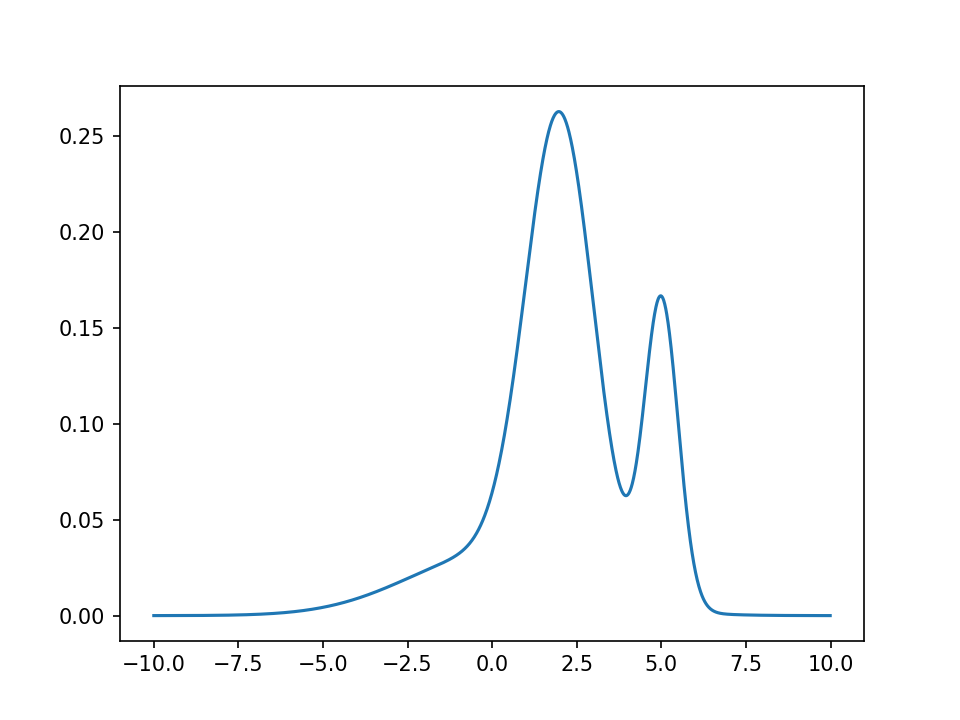

In [5]:
%matplotlib notebook
%matplotlib notebook

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
plt.plot(x_lin.detach().cpu().numpy(), target(x_lin).detach().cpu().numpy())


In [32]:
lat_dim=10
nb_neur=10
output_dim=1

In [33]:
G=GNN(lat_dim,nb_neur,output_dim,sigma=1.,layers=3,activation=nn.ReLU)
print('%%% Submodules %%%')
for i in G.named_modules():
    print(i)
print('%%% Parameters %%%')
for i in G.named_parameters():
    print(i)


%%% Submodules %%%
('', GNN(
  (transformer): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
))
('transformer', Sequential(
  (0): Linear(in_features=10, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=1, bias=True)
))
('transformer.0', Linear(in_features=10, out_features=10, bias=True))
('transformer.1', ReLU())
('transformer.2', Linear(in_features=10, out_features=10, bias=True))
('transformer.3', ReLU())
('transformer.4', Linear(in_features=10, out_features=10, bias=True))
('transformer.5', ReLU())
('transformer.6', Linear(in_features=10, out_features=1,

In [34]:
def init_weightsOut(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight,mean=0., std=5.)
        torch.nn.init.constant_(m.bias,0.)

#for c in range(G.nb_comp)
        
G.transformer[6].apply(init_weightsOut)



Linear(in_features=10, out_features=1, bias=True)

<IPython.core.display.Javascript object>


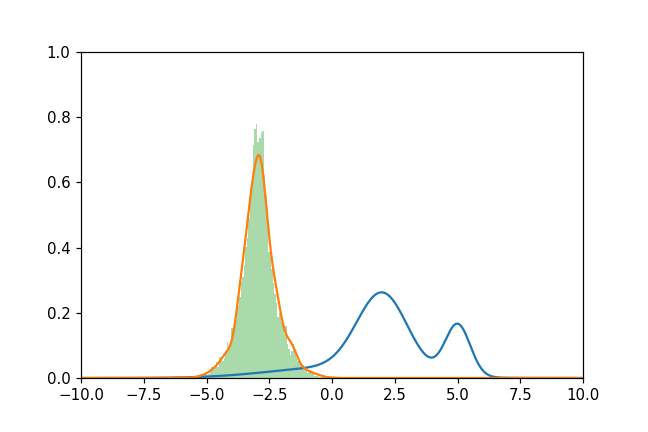

In [35]:
%matplotlib notebook
%matplotlib notebook
import seaborn as sns


x_lin = torch.arange(-10, 10.0, 0.001).unsqueeze(-1)
plt.plot(x_lin.detach().cpu().numpy(), target(x_lin).detach().cpu().numpy())
plt.plot(x_lin.detach().cpu().numpy(), G.KDE(x_lin,2000).exp().detach().cpu().numpy())

ax = sns.distplot(G(10000).detach().numpy(), bins=100, norm_hist =True, kde=False)

ax.set_xlim(-10,10)

ax.set_ylim(0,1)
ax.set_label(['target','KDE','histo'])


In [15]:
GNN_optimizer = torch.optim.Adam(G.parameters(), lr=.00001)
GNN_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(GNN_optimizer, patience=50, factor=0.5)
%matplotlib inline
liveloss = PlotLosses()

In [16]:
n_samples_KDE=2000
n_samples_VAR=2000

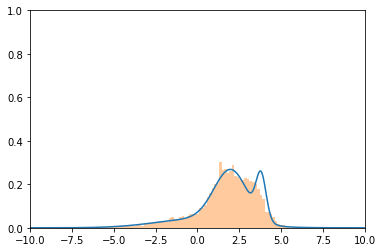

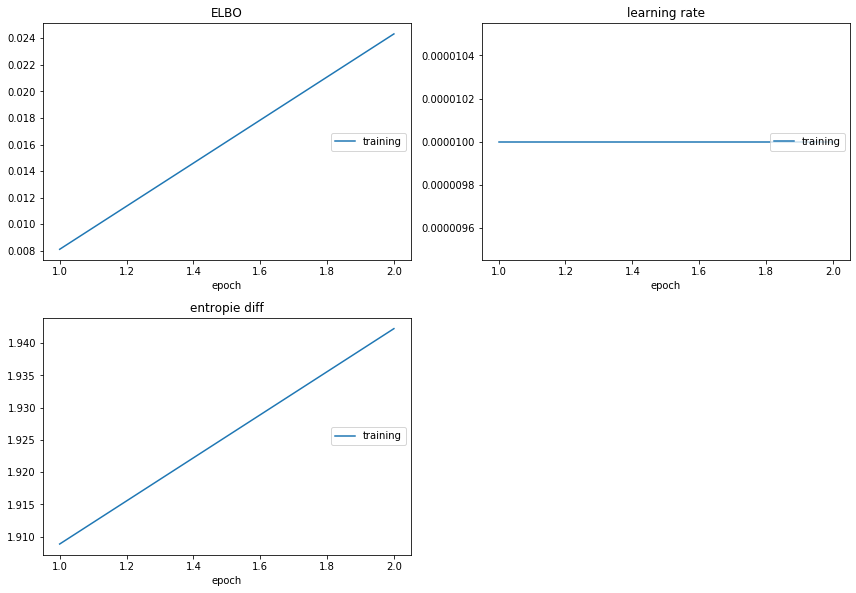

ELBO:
training   (min:    0.008, max:    0.024, cur:    0.024)

learning rate:
training   (min:    0.000, max:    0.000, cur:    0.000)

entropie diff:
training   (min:    1.909, max:    1.942, cur:    1.942)


KeyboardInterrupt: 

In [17]:
%matplotlib inline
for t in range(10000):
    logs = {}
    GNN_optimizer.zero_grad()

    learning_rate = GNN_optimizer.param_groups[0]['lr']
    
    theta=G(n_samples_VAR)
 
    ED=G.KDE(theta,n_samples_KDE).mean()
    LP=logtarget(theta).mean()
    
    L =ED-LP 

    L.backward()
    

    

    GNN_scheduler.step(L.detach().clone().cpu().numpy())

    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    logs['entropie diff'] = -ED.detach().clone().cpu().numpy()
    liveloss.update(logs)

   
    
    if t % 1 == 0:
        x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
        plt.plot(x_lin.detach().cpu().numpy(), target(x_lin).detach().cpu().numpy())

        ax = sns.distplot(G(10000).detach().numpy(), bins=100, norm_hist =True, kde=False)
        ax.set_xlim(-10,10)
        ax.set_ylim(0,1)

        liveloss.draw()

    GNN_optimizer.step()

    if learning_rate < 0.00000001:
        break

# Ensemble #

In [6]:
nb_comp=2

In [7]:
lat_dim=10
nb_neur=10
output_dim=1

In [24]:
G=GNNens(nb_comp,lat_dim,nb_neur,output_dim,sigma=1.,layers=3,activation=nn.ReLU)
print('%%% Submodules %%%')
for i in G.named_modules():
    print(i)
print('%%% Parameters %%%')
for i in G.named_parameters():
    print(i)


%%% Submodules %%%
('', GNNens(
  (components): ModuleList(
    (0): GNN(
      (transformer): Sequential(
        (0): Linear(in_features=10, out_features=10, bias=True)
        (1): ReLU()
        (2): Linear(in_features=10, out_features=10, bias=True)
        (3): ReLU()
        (4): Linear(in_features=10, out_features=10, bias=True)
        (5): ReLU()
        (6): Linear(in_features=10, out_features=1, bias=True)
      )
    )
    (1): GNN(
      (transformer): Sequential(
        (0): Linear(in_features=10, out_features=10, bias=True)
        (1): ReLU()
        (2): Linear(in_features=10, out_features=10, bias=True)
        (3): ReLU()
        (4): Linear(in_features=10, out_features=10, bias=True)
        (5): ReLU()
        (6): Linear(in_features=10, out_features=1, bias=True)
      )
    )
  )
))
('components', ModuleList(
  (0): GNN(
    (transformer): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1

In [25]:
def init_weightsOut(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight,mean=0., std=15.)
        torch.nn.init.constant_(m.bias,0.)

for c in range(G.nb_comp):        
    G.components[c].transformer[6].apply(init_weightsOut)



<IPython.core.display.Javascript object>


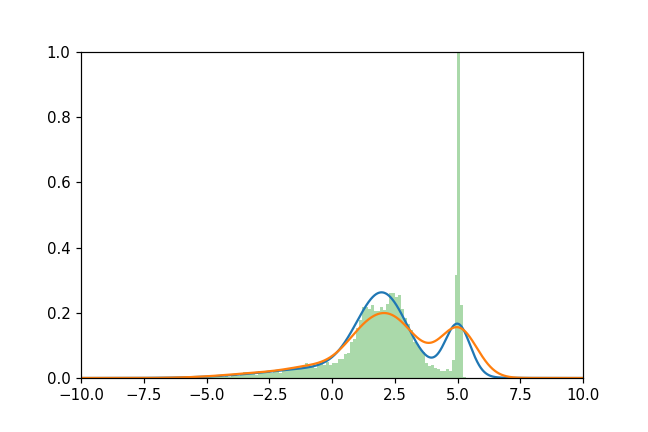

(0, 1)

In [49]:
%matplotlib notebook
%matplotlib notebook
import seaborn as sns


x_lin = torch.arange(-10, 10.0, 0.001).unsqueeze(-1)
plt.plot(x_lin.detach().cpu().numpy(), target(x_lin).detach().cpu().numpy())
theta,H=G.get_H(1000)
plt.plot(x_lin.detach().cpu().numpy(), G.KDE(theta, H, x_lin).exp().detach().cpu().numpy())


#for c in range(G.nb_comp):  
#    ax = sns.distplot(G.components[c](10000).detach().numpy(), bins=100, norm_hist =True, kde=False)

ax = sns.distplot(G(10000).detach().numpy(), bins=100, norm_hist =True, kde=False)
ax.set_xlim(-10,10)
ax.set_ylim(0,1)


In [45]:
GNN_optimizer = torch.optim.Adam(G.parameters(), lr=.01)
GNN_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(GNN_optimizer, patience=50, factor=0.5)
%matplotlib inline
liveloss = PlotLosses()

In [46]:
n_samples_KDE=1000
n_samples_VAR=500

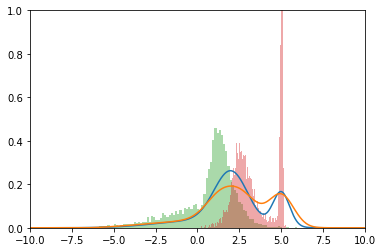

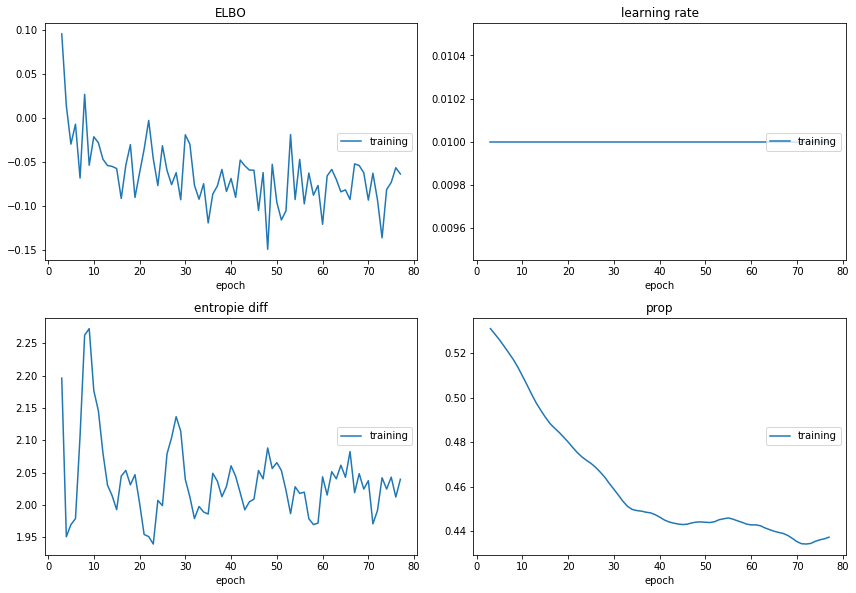

ELBO:
training   (min:   -0.150, max:    0.096, cur:   -0.064)

learning rate:
training   (min:    0.010, max:    0.010, cur:    0.010)

entropie diff:
training   (min:    1.939, max:    2.273, cur:    2.040)

prop:
training   (min:    0.434, max:    0.531, cur:    0.437)


KeyboardInterrupt: 

In [47]:
%matplotlib inline
for t in range(10000):
    logs = {}
    GNN_optimizer.zero_grad()

    learning_rate = GNN_optimizer.param_groups[0]['lr']
    
    theta, H=G.get_H(n_samples_KDE)
    
    K=torch.Tensor(G.nb_comp)
    LP=torch.Tensor(G.nb_comp)
    for c in range(G.nb_comp):
        K[c]=G.KDE(theta,H.detach(), G.components[c](n_samples_VAR)).mean()
        LP[c]=logtarget(G.components[c](n_samples_VAR)).mean()
        
    ED=torch.dot(G.proportions, K)
    LP_=torch.dot(G.proportions, LP)
    
    L =ED-LP_

    L.backward()
    

    

    GNN_scheduler.step(L.detach().clone().cpu().numpy())

    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    logs['entropie diff'] = -ED.detach().clone().cpu().numpy()
    logs['prop'] = G.proportions[0].detach().clone().cpu().numpy()
    liveloss.update(logs)

   
    
    if t % 1 == 0:
        x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
        plt.plot(x_lin.detach().cpu().numpy(), target(x_lin).detach().cpu().numpy())
        plt.plot(x_lin.detach().cpu().numpy(), G.KDE(theta, H, x_lin).exp().detach().cpu().numpy())
        ax = sns.distplot(G.components[0](5000).detach().numpy(), bins=100, norm_hist =True, kde=False)
        ax = sns.distplot(G.components[1](5000).detach().numpy(), bins=100, norm_hist =True, kde=False)
        ax.set_xlim(-10,10)
        ax.set_ylim(0,1)

        liveloss.draw()

    GNN_optimizer.step()

    if learning_rate < 0.00000001:
        break